# Import libraries

In [1]:
# basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# pythorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader, random_split, TensorDataset, Dataset, WeightedRandomSampler
from torch.cuda.amp import GradScaler, autocast
import torchvision
from torchvision import models
import torchvision.transforms as T

# sklearn
import sklearn
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics as skm
from sklearn.metrics import classification_report, confusion_matrix

#helper
from tqdm import tqdm

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Inspect Image meta-data dftrain

In [3]:
dftrain = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
dftrain.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.98, 'Cancer distribution')

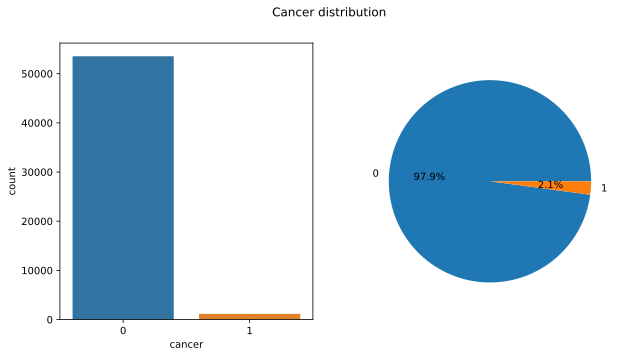

In [4]:
import seaborn as sns
from IPython import display
display.set_matplotlib_formats('svg')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
########## PLOTING CANCER ################
splot = sns.countplot(ax = axes[0], x = dftrain['cancer'])

s = dftrain['cancer'].value_counts()
axes[1].pie(s, autopct="%.1f%%", labels = s.keys())
fig.suptitle('Cancer distribution')

# Splits validation sets in 5 folds

In [5]:
from sklearn.model_selection import StratifiedGroupKFold

n_splits = 5

# Define the StratifiedGroupKFold object
sgkf = StratifiedGroupKFold(n_splits=n_splits)

# Split the data into n_splits folds
for i, (train_index, val_index) in enumerate(sgkf.split(dftrain, dftrain['cancer'], dftrain['patient_id'])):
    
    # Mark the fold for each row in the DataFrame
    dftrain.loc[val_index, 'splits'] = i # why val_index here? solved. CV concepts. splits into indices for n folds, the indices yieds from splits not the same with dftrain original indices.
                                         # n StratifiedGroupKFold, each fold is used as a validation set once and as a training set n_splits - 1 times. 


# Convert the 'splits' column to integer type
dftrain['splits'] = dftrain['splits'].astype(int)
dftrain.groupby('splits').cancer.mean()

splits
0    0.021127
1    0.021096
2    0.021205
3    0.021209
4    0.021203
Name: cancer, dtype: float64

# Create custom dataset

In [6]:
class RSNAMamographyDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
        

    def __getitem__(self, ind):
        
        img_path = f"{self.img_dir}/{self.df.iloc[ind].patient_id}_{self.df.iloc[ind].image_id}.png"
        img = Image.open(img_path).convert('RGB')
        
        label = torch.tensor(self.df.iloc[ind].cancer).to(torch.float32)
        
        # there is no need to normalize data, it has already been normalized
        if self.transform:
            img = self.transform(img).to(torch.float32) 
        else:
            default_transform = T.Compose([T.ToTensor()])
            img = default_transform(img).to(torch.float32)
            
        #sample = {"image" : img, "label": label}
        return img, label

In [7]:
augmentator = T.Compose([
    # input for augmentator is always PIL image
    # T.ToPILImage(),
    T.RandomResizedCrop((1024,512),scale=(0.8, 1), ratio=(0.45, 0.55)),
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.RandomRotation(degrees=(-5, 5)),
    T.ToTensor(),
    T.Normalize(mean=0.2179, std=0.0529)
])

In [8]:
import timm
from timm import create_model, list_models
from timm.data import create_transform

In [9]:
class TransferModel(torch.nn.Module):
    def __init__(self, model_type, nclass, pretrain=None, dropout=0.):
        super().__init__()
        
        self.model = create_model(model_type, pretrained=pretrain, num_classes=nclass, drop_rate=dropout)
        
    def forward(self, x):
  
        x = self.model(x)

        return torch.sigmoid(x)

nclass=1
model_type=['seresnext50_32x4d', 'efficientnet_b2', 'efficientnet_b4','efficientnetv2_xl', ]


# Competision metrics-PF1


In [10]:
def pfbeta(labels, preds, beta=1):
    y_true_count = labels.sum()
    ctp = preds[labels == 1].sum()
    cfp = preds[labels == 0].sum()
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0.0

# define the best thr for the optimal f1
def optimal_f1(labels, preds):
    thres = np.linspace(0, 1, 101)
    f1s = [pfbeta(labels, preds > thr) for thr in thres]
    idx = np.argmax(f1s)
    return f1s[idx], thres[idx]


In [11]:
# define the function to evaluate model performance

batch_size=16
lossfun=nn.BCEWithLogitsLoss()

def evaluate_model(model: TransferModel, ds, shuffle=False):
    torch.manual_seed(42)
    model = model.to(device)
    dataLoader_eval= torch.utils.data.DataLoader(ds, batch_size, shuffle=shuffle, pin_memory=False)
    
    preds = []
    targets=[]
    losses = []
    model.eval()
    for X,y in dataLoader_eval:
        with autocast(enabled=True):
            y = y[:,None]
            y = y.to(device)
            X = X.to(device)
            with torch.no_grad():
                yHat = model.forward(X)
                loss = lossfun(yHat, y).item() 
        losses.append(loss)           
        preds.append(yHat.cpu().numpy())
        targets.append(y.cpu().numpy())      
    
    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    pf1, thres = optimal_f1(targets, preds)
    
    return np.mean(losses), (pf1, thres), preds

In [12]:
# to avoid runtime out error 
import gc
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

# Train the Model

In [19]:
import copy
def train_model(ds_train, ds_eval, model_type, numepochs, one_cycle=None):
    # training parameters preparations 
    torch.manual_seed(42)
    dataLoader_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, pin_memory=True)
    
    model = TransferModel(model_type, nclass, True).to(device)
    optimizer = torch.optim.Adam(model.parameters())
  
    scheduler = None
    if one_cycle:
        
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=float(0.0004),
                                                        epochs=numepochs,
                                                        steps_per_epoch=int(len(dataLoader_train)),
                                                        pct_start=float(0.1))
    scaler = GradScaler()
    # initialize losses
    trainLoss = torch.zeros(numepochs)
    val_matrics  = torch.zeros((numepochs,3))

    # initialize best model
    best_model={'pf1 score': 0,
                'threshold': 0,
                'bestNetStateDict': None}
    
    # training epochs loop
    for epochi in range(numepochs):
        model.train()
        batchLoss=[]
        #training loop
        for X,y in dataLoader_train:
            y=y[:,None]
            
      
            optimizer.zero_grad()       
            # Using mixed precision training
            with autocast():
                yHat=model(X.to(device))
                loss=lossfun(yHat,y.to(device))
                if np.isinf(loss.item()) or np.isnan(loss.item()):
                        print(f'Bad loss, skipping the batch {batch_idx}')
                        del loss, yHat
                        gc_collect()
                        continue
                
            # scaler is needed to prevent "gradient underflow"    
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            if scheduler is not None:
                scheduler.step() # Update learning rate and momentum using One Cycle Policy
            scaler.update()
            lr = scheduler.get_last_lr()[0] if scheduler else 0.0004

            # recod batch training loss
            batchLoss.append(loss.item())
        
        trainLoss[epochi]=np.mean(batchLoss)           
    
        #validation loop
        if ds_eval is not None:
            loss, (pf1, thres), preds=evaluate_model(model,ds_eval)
            val_matrics[epochi,:]=loss, pf1, thres
            if pf1 > best_model['pf1 score']:
                best_model['pf1 score']=pf1
                best_model['threshold']=thres
                best_model['bestNetStateDict']=copy.deepcopy(model.state_dict())
            
        print(f'Finished epoch {epochi+1}/{numepochs}. valLoss={val_matrics[epochi,0]:.4f}. val pf1 score = {val_matrics[epochi,1]:.4f}. threshodd={val_matrics[epochi,2]:.4f}')
  
    # Save the best model state dict
    torch.save({'model_net': best_model['bestNetStateDict'], 'threshold': best_model['threshold'], 'model_name': model_type}, f'{model_path}/{model_type}.pt')      
  
    return best_model, trainLoss, val_matrics

In [20]:
model_path='/kaggle/working/'
def load_model(model_type, model_path, model=None):
    loading_model = torch.load(f'{model_path}/{model_type}.pt', f'{model_type}', map_location=device)
    if model is None:
        model = TransferModel(loading_model['model_type'],nclass, False)
    model.load_state_dict(loading_model['model_net'])
    return model, loading_model['threshold'], loading_model['model_type']

In [21]:
TRAIN_IMAGES_PATH='/kaggle/input/rsna-breast-cancer-detection-poi-images/bc_1280_train_lut'
# N-fold models. Can be used to estimate accurate CV score and in ensembled submissions.
for fold in range(n_splits):
    gc_collect()
    ds_train = RSNAMamographyDataset(dftrain.query('splits != @fold'), TRAIN_IMAGES_PATH, augmentator)
    ds_eval = RSNAMamographyDataset(dftrain.query('splits == @fold'), TRAIN_IMAGES_PATH, augmentator)
    train_model(ds_train,ds_eval,model_type[0], 3, True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/seresnext50_32x4d_racm-a304a460.pth" to /root/.cache/torch/hub/checkpoints/seresnext50_32x4d_racm-a304a460.pth


OutOfMemoryError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 15.90 GiB total capacity; 15.07 GiB already allocated; 39.75 MiB free; 15.10 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Cross Validation

In [ ]:
def gen_predictions(models, df_train):
    df_train_predictions = []
    with tqdm(enumerate(models), total=len(models), desc='Folds') as progress:
        for fold, model in progress:
            if model is not None:
                ds_eval = BreastCancerDataSet(df_train.query('split == @fold'), TRAIN_IMAGES_PATH, get_transforms(aug=False))

                cancer_loss, (f1, thres), pred_cancer = evaluate_model(model, ds_eval, PREDICT_MAX_BATCHES)[:3]
                progress.set_description(f'Eval fold:{fold} pF1:{f1:.02f}')
                df_pred = pd.DataFrame(data=pred_cancer,
                                              columns=['cancer_pred_proba'])
                df_pred['cancer_pred'] = df_pred.cancer_pred_proba > thres

                df = pd.concat(
                    [df_train.query('split == @fold').reset_index(drop=True), df_pred],
                    axis=1
                ).sort_values(['patient_id', 'image_id'])
                df_train_predictions.append(df)
    df_train_predictions = pd.concat(df_train_predictions)
    return df_train_predictions

if CV:
    models = [load_model(model, MODELS_PATH, BreastCancerModel(AUX_TARGET_NCLASSES))[0] for model in sorted(os.listdir(MODELS_PATH))]
    df_pred = gen_predictions(models, df_train)
    df_pred.to_csv('train_predictions.csv', index=False)
    !head train_predictions.csv



In [ ]:
if CV:
    df_pred = pd.read_csv('train_predictions.csv')
    print('F1 CV score (multiple thresholds):', sklearn.metrics.f1_score(df_pred.cancer, df_pred.cancer_pred))    
    df_pred = df_pred.groupby(['patient_id', 'laterality']).agg(
        cancer_max=('cancer_pred_proba', 'max'), cancer_mean=('cancer_pred_proba', 'mean'), cancer=('cancer', 'max')
    )
    print('pF1 CV score. Mean aggregation, single threshold:', optimal_f1(df_pred.cancer.values, df_pred.cancer_mean.values))
    print('pF1 CV score. Max aggregation, single threshold:', optimal_f1(df_pred.cancer.values, df_pred.cancer_max.values))

#Confusion matrix

In [ ]:
conf=skm.confusion_matrix(target.to(torch.long), predictions_bestnet.to(torch.long))
conf